Rename a bunch of files using Git and renamer?



In [ ]:
var execSync = require('child_process').execSync;
try {
    require.resolve('renamer');
} catch (e) {
    execSync('npm install renamer');
}
var renamer = require('renamer');
var renameUsingGit = (root, match, find, replace) => {
    var files = renamer.expand(path.join(root, match));
    var results = renamer.replace({
        files: files.filesAndDirs, 
        find: find, 
        replace: replace});
    return renamer.dryRun(results).list.map(r => {
        // rename with git instead
        var output = execSync('git ' 
                 + '--work-tree=' + JSON.stringify(root)
                 + ' --git-dir=' + JSON.stringify(path.join(root, '.git'))
                 + ' mv ' + JSON.stringify(r.before) 
                 + ' ' + JSON.stringify(r.after));
        return output.toString() || r.after;
    });
};
(renameUsingGit);


In [ ]:
// test it
// rename all scss files to less
renameUsingGit(
    '/Users/briancullinan/Documents/portal',
    'src/**/*.scss',
    '.scss',
    '.less');

How to use memory-fs and rewire to audit cli events?



In [ ]:
var path = require('path');
var execSync = require('child_process').execSync;
try {
    require.resolve('mock-require');
    require.resolve('unionfs');
    require.resolve('typescript');
    require.resolve('memfs');
} catch (e) {
    execSync('npm install mock-require memfs typescript unionfs');
}
// TODO: use https://github.com/jhnns/rewire for replacing variables, something like https://github.com/mariocasciaro/object-path?

var mockTypescriptFs = (root, data) => {
    var mock = require('mock-require');
    var memfs = require('memfs');
    var mem = new memfs.Volume;
    var unionfs = require('unionfs');
    var fs = require('fs');
    
    mem.mountSync(root, data);

    // Create a union of two file systems:
    unionfs
        .use(fs)
        .use(mem)
        .replace(fs);
    
    var ts = require('typescript');
    var tsMock = Object.assign({}, ts);
    var toMock = {
        readFile: 'readFileSync',
        realpath: 'realpathSync',
        writeFile: 'writeFileSync',
        fileExists: 'existsSync',
        directoryExists: 'existsSync',
        createDirectory: 'mkdirSync',
        getDirectories: 'readdirSync'
    };
    Object.keys(toMock)
        .forEach(k => {
            if(typeof mem[toMock[k]] === 'function') {
                tsMock.sys[k] = function () {
                    // typescript.sys functions return defined on error
                    try {
                        return mem[toMock[k]].apply(mem, arguments);
                    } catch (e) {
                        return;
                    }
                };
            }
        });

    mock('typescript', tsMock);
    return mock;
};
(mockTypescriptFs);

// TODO: search github for projects like graceful-fs and then search google for projects that use graceful-fs and see if we can record some filesystem activity



In [ ]:

mockTypescriptFs();


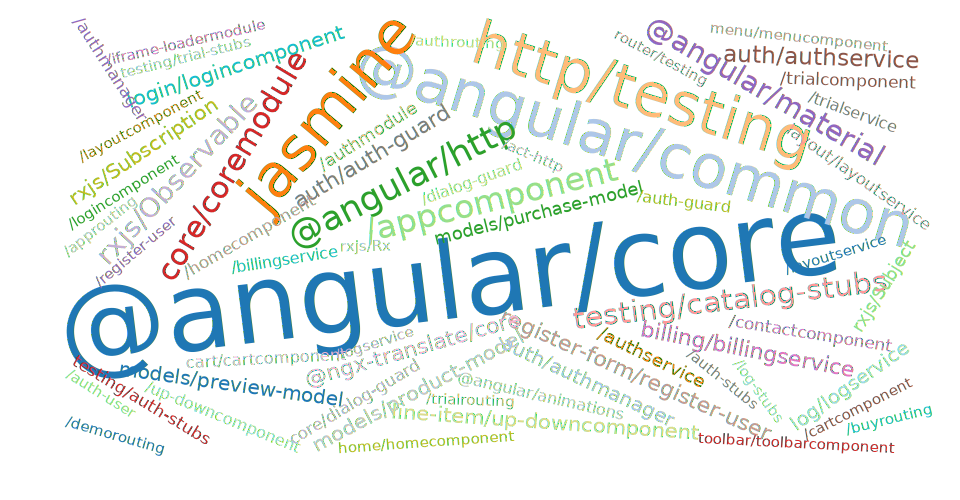

In [31]:
// TODO: break up d3 from file collection and create a gulp stream angular component out of it

var path = require('path');
var execSync = require('child_process').execSync;
try {
    require.resolve('gulp');
    require.resolve('gulp-tap');
    require.resolve('d3-node');
    require.resolve('d3-cloud');
    require.resolve('canvas');
} catch (e) {
    execSync('npm install "github:gulpjs/gulp.git#4.0" gulp-tap d3-node d3-cloud canvas');
}

var gulp = require('gulp');
var tap = require('gulp-tap');
var cloud = require('d3-cloud');

var PROFILE_PATH = process.env.HOME || process.env.HOMEPATH || process.env.USERPROFILE;
var project = PROFILE_PATH + '/Documents/portal';


var Canvas = require("canvas");
var D3Node = require('d3-node');
var d3n = new D3Node(); // initializes D3 with container element 
var d3 = d3n.d3;

var margin = {top: 20, right: 20, bottom: 30, left: 50},
    width = 960 - margin.left - margin.right,
    height = 500 - margin.top - margin.bottom;

var fill = d3.scaleOrdinal(d3.schemeCategory20);

var svg = d3n.createSVG(width + margin.left + margin.right,
                        height + margin.top + margin.bottom)
  .append("g")
    .attr("transform",
          "translate(" + (margin.left + width / 2) + "," + (margin.top + height / 2) + ")");

var wordCount = {};
function draw(wordCount) {
    svg.selectAll("text")
    .data(wordCount)
    .enter().append("text")
    .style("font-size", function(d) { return d.size + "px"; })
    .style("font-family", "Impact")
    .style("fill", function(d, i) { return fill(i); })
    .attr("text-anchor", "middle")
    .attr("transform", function(d) {
         return "translate(" + [d.x, d.y] + ")rotate(" + d.rotate + ")";
    })
    .text(function(d) { return d.text; });
    
    $$.svg(d3n.svgString());
}

var words = [];
gulp.task('default', function() {
    return gulp.src(['src/**/*.ts'], {cwd: project})
        .pipe(tap(function (file) {
            var content = file.contents.toString();
            var re = /from\s+.*?["'](.*?)['"]/ig;
            var m;
            while ((m = re.exec(content))) {
                words[words.length] = m[1];
            }
        }));
});

$$.async()
try {
gulp.series(() => gulp.task(['default'])(), function (done) {
    done();
    
    words.forEach(w => {
        var word = w.split('/').slice(w.split('/').length-2).join('#').replace(/[\/\.]/ig, '').replace('#', '/');
        if(typeof wordCount[word] == 'undefined') {
            wordCount[word] = 15;
        } else {
            wordCount[word]++;
        }
    });
    wordCount = Object.keys(wordCount).map(function(d) {
         return {text: d, size: wordCount[d]};
    });
    
    cloud()
        .canvas(function() { return new Canvas(1, 1); })
        .size([width, height])
        .words(wordCount)
        .padding(0)
        .rotate(function() { return ~~(Math.random() * 120) - 60; })
        .font("Impact")
        .fontSize(function(d) { return d.size; })
        .on("end", draw)
        .start();
})();
} catch (e) {
    $$.sendError(e);
}

